<a href="https://colab.research.google.com/github/gibsonx/skeleton/blob/master/aspine_dataset_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!git clone https://github.com/gibsonx/skeleton.git
sys.path.append('/content/skeleton')
!pip install -r '/content/skeleton/requirements.txt' &> /dev/null

Cloning into 'skeleton'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 38 (delta 12), reused 20 (delta 4), pack-reused 0
Unpacking objects: 100% (38/38), 9.24 MiB | 5.01 MiB/s, done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os, json, cv2, numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.datasets import CocoDetection
import albumentations as A # Library for augmentations

In [4]:
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [5]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [8]:
keypoints_classes_ids2names = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '80', 81: '81', 82: '82', 83: '83', 84: '84', 85: '85', 86: '86', 87: '87', 88: '88', 89: '89', 90: '90', 91: '91', 92: '92', 93: '93', 94: '94', 95: '95', 96: '96', 97: '97', 98: '98', 99: '99', 100: '100', 101: '101', 102: '102', 103: '103', 104: '104', 105: '105', 106: '106', 107: '107', 108: '108', 109: '109', 110: '110', 111: '111', 112: '112', 113: '113', 114: '114', 115: '115', 116: '116', 117: '117', 118: '118', 119: '119', 120: '120', 121: '121', 122: '122', 123: '123', 124: '124', 125: '125', 126: '126', 127: '127', 128: '128', 129: '129', 130: '130', 131: '131', 132: '132', 133: '133', 134: '134', 135: '135', 136: '136'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 2

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)

    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            # image = cv2.putText(image.copy(), "" + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        plt.show()
        print('no keypoint')
    else:
        print('keypoint is found')
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)

        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                # image_original = cv2.putText(image_original, "     " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        plt.show()

##########CocoDataset########

In [17]:
import os.path
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image

class CocoDataset(CocoDetection):

    def __init__(
        self,
        root: str,
        annFile: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
        demo = False
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)


    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)

        img_original = np.array(image)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        bboxes_original = []
        for i in target:
            bboxes_original.append([ i['bbox'][0], i['bbox'][1], i['bbox'][0] + i['bbox'][2], i['bbox'][1] + i['bbox'][3]])


        keypoints_original = [[list(a) for a in zip(*[iter(i['keypoints'])]*3)] for i in target]

        bboxes_labels_original = ['137points' for _ in bboxes_original]

        if self.transform:
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]


            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']

            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,137,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)

        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original

        # Convert everything into a torch tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([id])
        # target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)

        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([id])
        # target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target

    def __len__(self) -> int:
        return len(self.ids)

        return image, target

In [10]:
root_path = "/content/drive/MyDrive/Dataset/sk0413/images"
json_path = "/content/drive/MyDrive/Dataset/sk0413/annotations/person_keypoints_default.json"

dataset = CocoDataset(annFile=json_path,root=root_path,transform=train_transform(), demo=True)

data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)



loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
[350.48, 22.02, 546.35, 1909.59]


In [11]:
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

keypoint is found


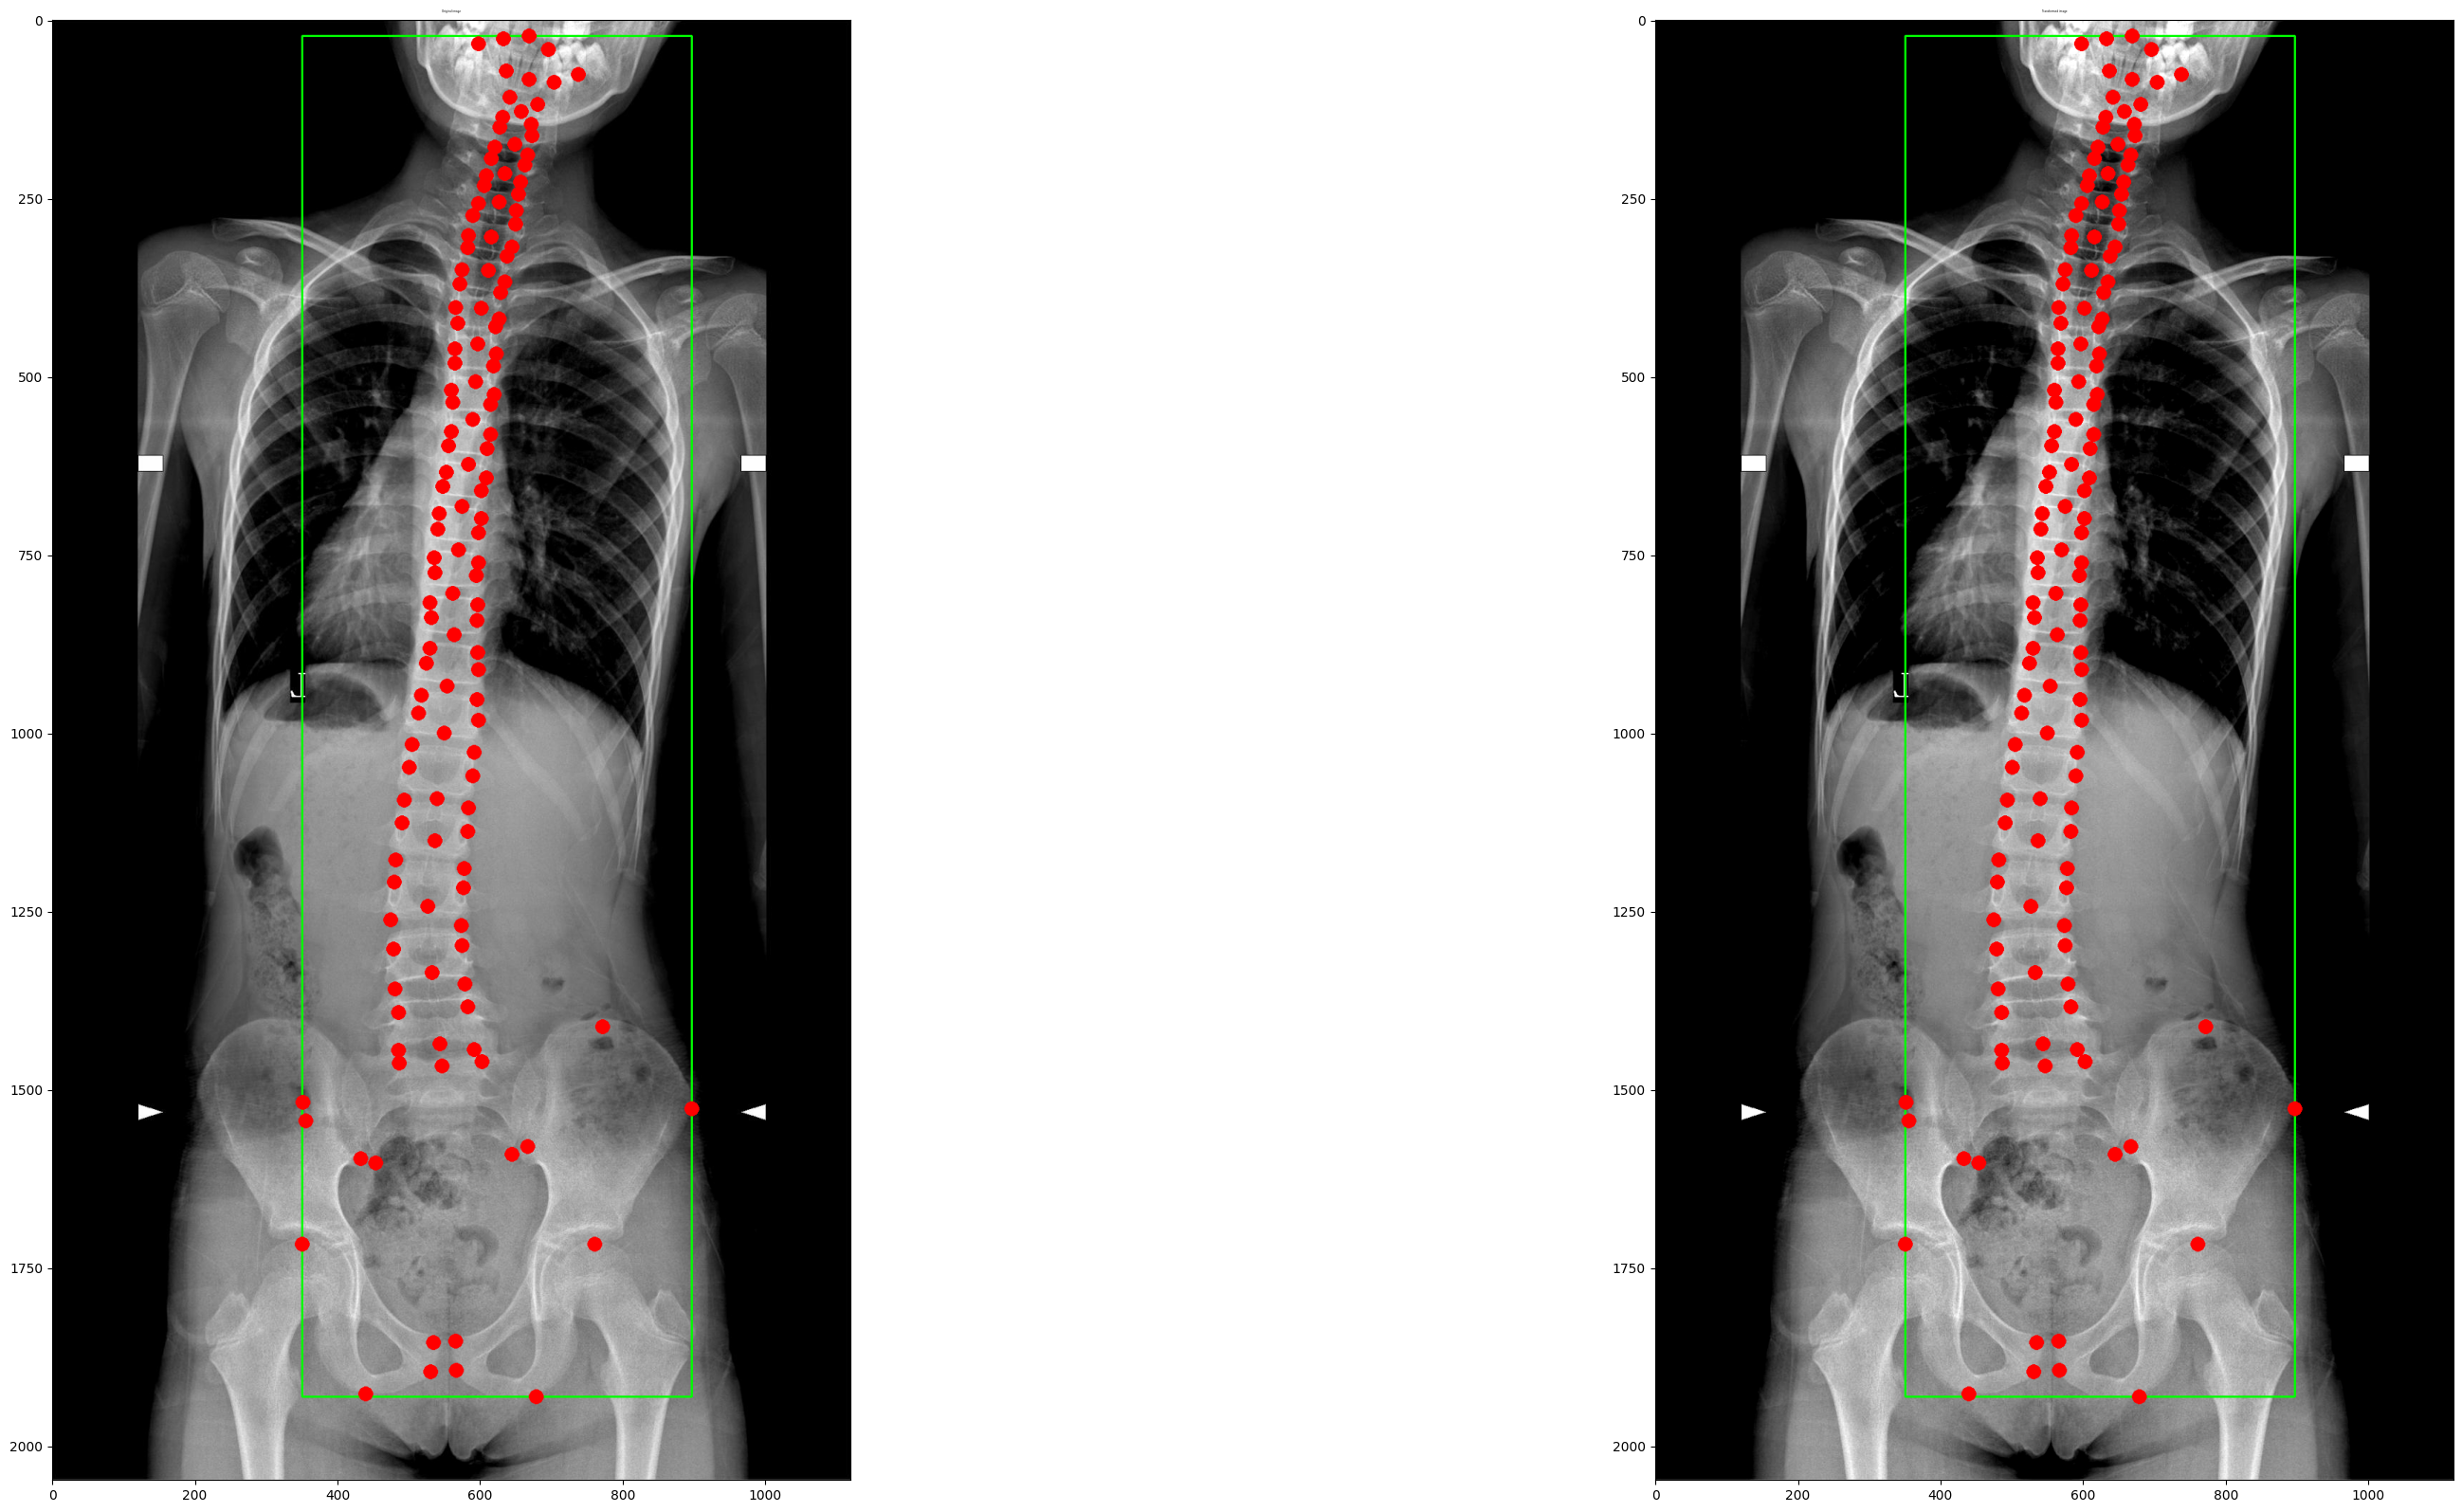

In [12]:
visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [18]:
def get_model(num_keypoints, weights_path=None):

    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

    return model

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('training with GPU')
else:
    print('training with cpu')
    device = torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = "/content/drive/MyDrive/Dataset/sk0413/annotations/person_keypoints_default.json"
KEYPOINTS_FOLDER_TEST = "/content/drive/MyDrive/Dataset/sk0413/annotations/person_keypoints_default.json"

dataset_train = CocoDataset(annFile=KEYPOINTS_FOLDER_TRAIN,root=root_path,transform=None, demo=False)
dataset_test = CocoDataset(annFile=KEYPOINTS_FOLDER_TEST,root=root_path, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=6, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# model = get_model(num_keypoints=137,weights_path='/content/drive/MyDrive/Dataset/keypointsrcnn_weights.pth')
model = get_model(num_keypoints=137)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 300

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=2000)
    lr_scheduler.step()
    # evaluate(model, data_loader_test, device)


# # Save model weights after training
torch.save(model.state_dict(), '/content/drive/MyDrive/Dataset/keypointsrcnn_weights.pth')

training with GPU
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Epoch: [0]  [ 0/12]  eta: 0:00:30  lr: 0.000092  loss: 9.4920 (9.4920)  loss_classifier: 0.6882 (0.6882)  loss_box_reg: 0.0017 (0.0017)  loss_keypoint: 8.0567 (8.0567)  loss_objectness: 0.6972 (0.6972)  loss_rpn_box_reg: 0.0483 (0.0483)  time: 2.5054  data: 0.6353  max mem: 10698
Epoch: [0]  [11/12]  eta: 0:00:02  lr: 0.001000  loss: 9.2630 (9.2346)  loss_classifier: 0.4551 (0.4368)  loss_box_reg: 0.0002 (0.0004)  loss_keypoint: 8.0567 (8.0507)  loss_objectness: 0.6957 (0.6944)  loss_rpn_box_reg: 0.0483 (0.0522)  time: 2.1622  data: 0.3915  max mem: 10929
Epoch: [0] Total time: 0:00:25 (2.1626 s / it)
Epoch: [1]  [ 0/12]  eta: 0:00:28  lr: 0.001000  loss: 8.7895 (8.7895)  loss_classifier: 0.0446 (0.0446)  loss_box_reg: 0.0003 (0.0003)  loss_keypoint: 7.9927 (7.9927)  loss_objectness: 0.6794 (0.6794)  loss

In [ ]:
iterator = iter(data_loader_test)

In [ ]:
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

In [ ]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

visualize(image, bboxes, keypoints)